In [2]:
from numpy import load
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

In [3]:
data = load('E:/Egyetem/data_sc/AI_szB/ok/pathmnist.npz')
lst = data.files
print(len(lst))
print("Adatok:")
for i in range(6):
    print(lst[i],':',len(data[lst[i]]), "db")

6
Adatok:
train_images : 89996 db
val_images : 10004 db
test_images : 7180 db
train_labels : 89996 db
val_labels : 10004 db
test_labels : 7180 db


In [4]:
target = [] #---> 0,1,2,3
image_data = [] #---->array

target = np.concatenate((data[lst[3]].flatten(), data[lst[4]].flatten(),data[lst[5]].flatten()))
image_data = np.concatenate((data[lst[0]], data[lst[1]],data[lst[2]]))

print(len(target))
print(len(image_data))

data_size = len(target)

107180
107180


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data,target, test_size=0.2)

In [6]:
print(len(X_train))
print(len(y_train))
print(len(X_test[21]))
print(len(y_test))

train_size = len(X_train)
test_size = len(X_test)

85744
85744
28
21436


In [7]:
#print(X_train[23])
X_train = X_train.reshape(train_size,3,28,28)
#print(X_train[23])
X_test = X_test.reshape(test_size,3,28,28)



In [8]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(3, 32, 3) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 3) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 3)

        x = torch.randn(28,28,3).view(-1,3,28,28)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 9)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)


In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [11]:
print(len(X_train), len(X_test))

85744 21436


In [12]:
training_data = []

training_data.append(image_data)
training_data.append(target)

print(len(training_data))

2


In [13]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [14]:
one_hot_encoding_y_test = []

one_hot_encoding_y_test = get_one_hot(y_test, 9)
one_hot_encoding_y_train = get_one_hot(y_train, 9)

In [15]:
#print(y_test)

for i in range(3):
    print(y_test[i])
    print(one_hot_encoding_y_test[i])
    print(y_train[i])
    print(one_hot_encoding_y_train[i])
    


4
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
2
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
7
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
2
[0. 0. 1. 0. 0. 0. 0. 0. 0.]
3
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
4
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [16]:
sample = X_test[0]

X_train = torch.Tensor(X_train).reshape(-1,3,28,28)
X_train = X_train/255.0
#X_train = torch.from_numpy(np.array(X_train, dtype=np.int))
y_train = torch.Tensor(one_hot_encoding_y_train)
#X_test = torch.from_numpy(np.array(X_test, dtype=np.int))
X_test = torch.Tensor(X_test).reshape(-1,3,28,28)
X_test = X_test/255.0
y_test = torch.Tensor(one_hot_encoding_y_test)



print(X_train.size())
print(X_test.size())

print(y_train.size())
print(y_test.size())

#print(X_test[0])
print(y_test[0])


torch.Size([85744, 3, 28, 28])
torch.Size([21436, 3, 28, 28])
torch.Size([85744, 9])
torch.Size([21436, 9])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [17]:
def set_acc():
    y_pred = []
    yy_test = []

    bad_dec = []
    real = []
    bad_num = 0
    bad_pics = []

    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(X_test))):
            real_class = torch.argmax(y_test[i])
            net_out = net(X_test[i].view(-1, 3, 28, 28))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            y_pred.append(predicted_class)
            yy_test.append(real_class)

            if predicted_class == real_class:
                correct += 1
            else:
                bad_num += 1
                bad_dec.append(predicted_class)
                real.append(real_class)
                bad_pics.append(X_test[i])
                #print(plt.imshow(test_X[i].reshape(100,100,3)))
            total += 1
    return round(correct/total, 3)

In [30]:
BATCH_SIZE = 64
EPOCHS = 30

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(X_train), BATCH_SIZE)): #
        batch_X = X_train[i:i+BATCH_SIZE].view(-1, 3, 28, 28)
        batch_y = y_train[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    #print(f"Epoch: {epoch}. Loss: {loss}.")
    print(f"Epoch: {epoch}. Loss: {loss}. Accuracy: {set_acc()}")

  0%|                                                                                         | 0/1340 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.034374672919511795. Accuracy: 0.761


  0%|                                                                                         | 0/1340 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.03934575989842415. Accuracy: 0.761


  0%|                                                                                 | 1/1340 [00:00<03:45,  5.94it/s]

Epoch: 2. Loss: 0.03602415695786476. Accuracy: 0.761


  0%|                                                                                 | 1/1340 [00:00<03:15,  6.85it/s]

Epoch: 3. Loss: 0.030385324731469154. Accuracy: 0.773


  0%|                                                                                 | 1/1340 [00:00<03:18,  6.76it/s]

Epoch: 4. Loss: 0.03468095883727074. Accuracy: 0.766


  0%|                                                                                 | 1/1340 [00:00<03:20,  6.67it/s]

Epoch: 5. Loss: 0.03013167716562748. Accuracy: 0.779


  0%|                                                                                 | 1/1340 [00:00<03:28,  6.41it/s]

Epoch: 6. Loss: 0.031437948346138. Accuracy: 0.779


  0%|                                                                                 | 1/1340 [00:00<03:16,  6.81it/s]

Epoch: 7. Loss: 0.026820896193385124. Accuracy: 0.776


  0%|                                                                                         | 0/1340 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.033548202365636826. Accuracy: 0.779


  0%|                                                                                 | 1/1340 [00:00<03:01,  7.39it/s]

Epoch: 9. Loss: 0.035268016159534454. Accuracy: 0.744


  0%|                                                                                 | 1/1340 [00:00<03:02,  7.35it/s]

Epoch: 10. Loss: 0.031789571046829224. Accuracy: 0.741


  0%|                                                                                 | 1/1340 [00:00<02:51,  7.83it/s]

Epoch: 11. Loss: 0.03279552981257439. Accuracy: 0.725


  0%|                                                                                 | 1/1340 [00:00<03:26,  6.50it/s]

Epoch: 12. Loss: 0.02923002280294895. Accuracy: 0.738


  0%|                                                                                 | 1/1340 [00:00<03:11,  7.00it/s]

Epoch: 13. Loss: 0.028950346633791924. Accuracy: 0.753


  2%|█▎                                                                              | 21/1340 [00:03<03:33,  6.19it/s]


KeyboardInterrupt: 

In [31]:
print(set_acc())

100%|███████████████████████████████████████████████████████████████████████████| 21436/21436 [00:58<00:00, 367.65it/s]

0.775


In [32]:
y_pred = []
yy_test = []
bad_dec = []
real = []
bad_num = 0
bad_pics = []
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        real_class = torch.argmax(y_test[i])
        net_out = net(X_test[i].view(-1, 3, 28, 28))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        y_pred.append(predicted_class)
        yy_test.append(real_class)

        if predicted_class == real_class:
            correct += 1
        else:
            bad_num += 1
            bad_dec.append(predicted_class)
            real.append(real_class)
            bad_pics.append(X_test[i])                #print(plt.imshow(test_X[i].reshape(100,100,3)))
        total += 1
print(correct/total,3)

100%|███████████████████████████████████████████████████████████████████████████| 21436/21436 [00:55<00:00, 389.34it/s]

0.7754245194999067 3


In [33]:
#confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yy_test,y_pred)
cm

array([[2307,   11,    5,    0,   32,   11,    8,    0,    4],
       [  97, 2126,    8,    0,   23,    1,    0,    2,    5],
       [  15,    6, 1561,   39,   41,  154,   63,  230,  235],
       [   4,    0,   10, 2290,    6,    0,   89,    6,   66],
       [ 180,   24,   21,   16, 1414,   17,  127,   39,   87],
       [  45,    4,  312,    9,   39, 1937,   53,  306,   90],
       [  45,    1,   20,   95,  233,   10, 1180,   18,  317],
       [   0,    1,  325,    5,   89,  177,   96, 1352,  161],
       [   2,    1,   95,   78,   52,   31,  302,  120, 2455]],
      dtype=int64)

Text(69.0, 0.5, 'Truth')

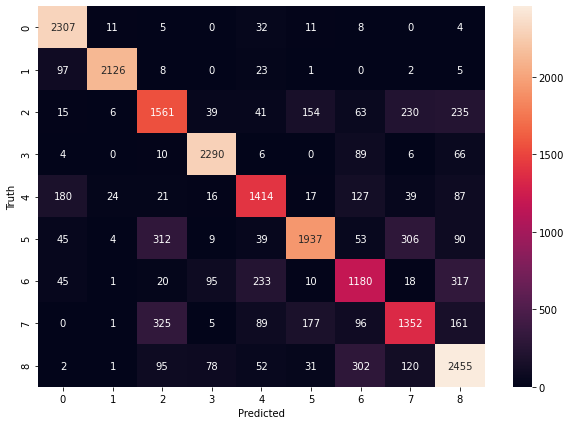

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')